In [3]:
# Importando as Bibliotecas

import pandas as pd

In [4]:
# Caminhos dos arquivos
caminho_genero = './dados/genero.csv'
caminho_faixa_etaria = './dados/faixa-etaria.csv'
caminho_educacao = './dados/educacao.csv'

In [5]:
# Leitura com encoding ajustado
df_genero = pd.read_csv(caminho_genero, encoding='latin1', sep=';', skiprows=3,nrows=27)
df_faixa_etaria = pd.read_csv(caminho_faixa_etaria, encoding='latin1',sep=';', skiprows=3,nrows=27)
df_educacao = pd.read_csv(caminho_educacao, encoding='latin1',sep=';', skiprows=3,nrows=27)

In [6]:
# Verificando colunas e valores nulos
print("🟦 Colunas - Gênero:", df_genero.columns.tolist())
print("🟨 Colunas - Faixa Etária:", df_faixa_etaria.columns.tolist())
print("🟩 Colunas - Escolaridade:", df_educacao.columns.tolist())

🟦 Colunas - Gênero: ['UF de residência', 'Ignorado', 'Masculino', 'Feminino', 'Total']
🟨 Colunas - Faixa Etária: ['UF de residência', 'Em branco/IGN', '<1 Ano', '1-4', '5-9', '10-14', '15-19', '20-39', '40-59', '60-64', '65-69', '70-79', '80 e +', 'Total']
🟩 Colunas - Escolaridade: ['UF de residência', 'Ign/Branco', 'Analfabeto', '1ª a 4ª série incompleta do EF', '4ª série completa do EF', '5ª a 8ª série incompleta do EF', 'Ensino fundamental completo', 'Ensino médio incompleto', 'Ensino médio completo', 'Educação superior incompleta', 'Educação superior completa', 'Não se aplica', 'Total']


In [7]:
print("\n🔍 Valores nulos por arquivo:")
print("Gênero:\n", df_genero.isnull().sum())
print("Faixa Etária:\n", df_faixa_etaria.isnull().sum())
print("Educação:\n", df_educacao.isnull().sum())


🔍 Valores nulos por arquivo:
Gênero:
 UF de residência    0
Ignorado            0
Masculino           0
Feminino            0
Total               0
dtype: int64
Faixa Etária:
 UF de residência    0
Em branco/IGN       0
<1 Ano              0
1-4                 0
5-9                 0
10-14               0
15-19               0
20-39               0
40-59               0
60-64               0
65-69               0
70-79               0
80 e +              0
Total               0
dtype: int64
Educação:
 UF de residência                  0
Ign/Branco                        0
Analfabeto                        0
1ª a 4ª série incompleta do EF    0
4ª série completa do EF           0
5ª a 8ª série incompleta do EF    0
Ensino fundamental completo       0
Ensino médio incompleto           0
Ensino médio completo             0
Educação superior incompleta      0
Educação superior completa        0
Não se aplica                     0
Total                             0
dtype: int64


In [8]:
# Exibindo as 5 primeiras linhas
print("\n📊 Amostra - Gênero")
print(df_genero.head())

print("\n📊 Amostra - Faixa Etária")
print(df_faixa_etaria.head())

print("\n📊 Amostra - Escolaridade")
print(df_educacao.head())



📊 Amostra - Gênero
  UF de residência Ignorado  Masculino  Feminino  Total
0      11 Rondônia        -        359       435    794
1          12 Acre        1       3628      4282   7911
2      13 Amazonas        -       1259      1435   2694
3       14 Roraima        -         68        67    135
4          15 Pará       11       4563      5203   9777

📊 Amostra - Faixa Etária
  UF de residência Em branco/IGN  <1 Ano  1-4  5-9  10-14  15-19  20-39  \
0      11 Rondônia             -      12   37   43     49     44    272   
1          12 Acre             1     105  326  586    691    793   2998   
2      13 Amazonas             1      54  132  188    217    218    986   
3       14 Roraima             -       3    5    7      7      6     61   
4          15 Pará             -     164  407  680    964   1191   3456   

   40-59  60-64  65-69  70-79  80 e +  Total  
0    242     34     20     35       6    794  
1   1704    252    167    204      83   7910  
2    609     97     66    

#### Inserir dados no Banco

In [9]:
# Importar Bibliotecas
from sqlalchemy import create_engine

In [10]:
import mysql.connector
# Conexão com o MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Senha_Banco',
    database='dengue_db'
)
cursor = conn.cursor()

# Função para salvar DataFrame no MySQL
def salvar_tabela(df, nome_tabela):
    # Cria a tabela dinamicamente (apaga se já existir)
    cursor.execute(f"DROP TABLE IF EXISTS {nome_tabela}")
    
    colunas = ', '.join([f"`{col}` TEXT" for col in df.columns])
    cursor.execute(f"CREATE TABLE {nome_tabela} ({colunas})")
    
    for _, row in df.iterrows():
        valores = ', '.join(['%s'] * len(row))
        sql = f"INSERT INTO {nome_tabela} VALUES ({valores})"
        cursor.execute(sql, tuple(row.astype(str)))
    conn.commit()
    print(f"✅ Tabela {nome_tabela} salva com sucesso!")

# Inserindo os três arquivos
salvar_tabela(df_genero, 'tb_casos_dengue_genero')
salvar_tabela(df_faixa_etaria, 'tb_casos_dengue_faixa_etaria')
salvar_tabela(df_educacao, 'tb_casos_dengue_educacao')

# Fechar a conexão
cursor.close()
conn.close()


✅ Tabela tb_casos_dengue_genero salva com sucesso!
✅ Tabela tb_casos_dengue_faixa_etaria salva com sucesso!
✅ Tabela tb_casos_dengue_educacao salva com sucesso!


#### Consumo Tratamento e Junção das Fontes de dados

In [11]:
# Conexão com o banco
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Senha_Banco',
    database='fiap'
)

# Lendo as tabelas para DataFrames
df_genero_my_sql = pd.read_sql("SELECT * FROM casos_dengue_genero", conn)
df_faixa_etaria_my_sql = pd.read_sql("SELECT * FROM casos_dengue_faixa_etaria", conn)
df_educacao_my_sql = pd.read_sql("SELECT * FROM casos_dengue_educacao", conn)

conn.close()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\417848634.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_genero_my_sql = pd.read_sql("SELECT * FROM casos_dengue_genero", conn)
C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\417848634.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_faixa_etaria_my_sql = pd.read_sql("SELECT * FROM casos_dengue_faixa_etaria", conn)
C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\417848634.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_educacao_my_sql = pd.rea

##### Ajustando o Genero

In [12]:
# Renomear colunas
df_genero_my_sql.columns = ['uf', 'ignorado', 'masculino', 'feminino', 'total']

# Separar código da UF e nome do estado
df_genero_my_sql[['cod_uf', 'uf_nome']] = df_genero_my_sql['uf'].str.extract(r'(\d+)\s+(.*)')

# Remover colunas desnecessárias
df_genero_my_sql = df_genero_my_sql.drop(columns=['uf', 'ignorado', 'total'])

# Conversão para numérico
df_genero_my_sql['masculino'] = pd.to_numeric(df_genero_my_sql['masculino'], errors='coerce')
df_genero_my_sql['feminino'] = pd.to_numeric(df_genero_my_sql['feminino'], errors='coerce')

# Preenchimento de valores nulos
df_genero_my_sql = df_genero_my_sql.fillna(0)

# Criar coluna alvo
df_genero_my_sql['casos_totais'] = df_genero_my_sql['masculino'] + df_genero_my_sql['feminino']

# Visualizar
print(df_genero_my_sql.head())


   masculino  feminino cod_uf    uf_nome  casos_totais
0       68.0      67.0     14    Roraima         135.0
1     4563.0    5203.0     15       Pará        9766.0
2      352.0     362.0     16      Amapá         714.0
3      787.0     967.0     17  Tocantins        1754.0
4      872.0    1032.0     21   Maranhão        1904.0


##### Ajustando a Educação

In [13]:
# Visualizar para entender a estrutura
print(df_educacao_my_sql.columns)
print(df_educacao_my_sql.head())

# Corrigir nomes das colunas
df_educacao_my_sql.columns = [
    'uf', 'ign_branco', 'analfabeto', 'serie_1a4_incompleta', 'serie_4_completa',
    'serie_5a8_completa', 'fundamental_completo', 'medio_completo', 
    'medio_incompleto', 'superior_incompleto', 'superior_completo', 
    'nao_se_aplica', 'total'
]

# Separar código da UF
df_educacao_my_sql[['cod_uf', 'uf_nome']] = df_educacao_my_sql['uf'].str.extract(r'(\d+)\s+(.*)')
df_educacao_my_sql = df_educacao_my_sql.drop(columns=['uf', 'total'])

# Converter todas as colunas (menos as UF) para numérico
colunas_numericas = df_educacao_my_sql.columns.difference(['cod_uf', 'uf_nome'])
df_educacao_my_sql[colunas_numericas] = df_educacao_my_sql[colunas_numericas].apply(pd.to_numeric, errors='coerce')

# Preencher nulos
df_educacao_my_sql = df_educacao_my_sql.fillna(0)

# Exibir resultado
print(df_educacao_my_sql.head())


Index(['13 Amazonas', '707', '88', '178', '64', '223', '198', '187', '645',
       '30', '87', '287', '2694'],
      dtype='object')
    13 Amazonas     707   88  178   64   223    198    187     645   30  \
0    14 Roraima    44.0    -   10    2    12    4.0   11.0    25.0    7   
1       15 Pará  2563.0  118  586  365  1201  514.0  976.0  1826.0  235   
2      16 Amapá   359.0    2   23   21    41   22.0   57.0   132.0   10   
3  17 Tocantins   440.0   16   80   44   127   94.0  132.0   415.0   54   
4   21 Maranhão   472.0   25   96   56   222   95.0  136.0   404.0   31   

      87    287    2694  
0    7.0   13.0   135.0  
1  441.0  952.0  9777.0  
2   19.0   30.0   716.0  
3  141.0  211.0  1754.0  
4   64.0  303.0  1904.0  
   ign_branco  analfabeto  serie_1a4_incompleta  serie_4_completa  \
0        44.0         0.0                  10.0               2.0   
1      2563.0       118.0                 586.0             365.0   
2       359.0         2.0                  23.0      

#### Ajustando a Faixa Etária

In [14]:
# Renomeando as colunas manualmente
df_faixa_etaria_my_sql.columns = [
    'uf','ignorado', 'idade_menor1', 'idade_1a4', 'idade_5a9', 'idade_10a14',
    'idade_15a19', 'idade_20a39', 'idade_40a59', 'idade_60a64', 'idade_65a69',
    'idade_70a79', 'idade_80mais', 'total'
]

# Separar código e nome da UF
df_faixa_etaria_my_sql[['cod_uf', 'uf_nome']] = df_faixa_etaria_my_sql['uf'].str.extract(r'(\d+)\s+(.*)')
df_faixa_etaria_my_sql = df_faixa_etaria_my_sql.drop(columns=['uf', 'ignorado', 'total'])

# Converter colunas para numérico
colunas_numericas = df_faixa_etaria_my_sql.columns.difference(['cod_uf', 'uf_nome'])
df_faixa_etaria_my_sql[colunas_numericas] = df_faixa_etaria_my_sql[colunas_numericas].apply(pd.to_numeric, errors='coerce')

# Tratar nulos
df_faixa_etaria_my_sql = df_faixa_etaria_my_sql.fillna(0)

# Exibir
print(df_faixa_etaria_my_sql.head())

   idade_menor1  idade_1a4  idade_5a9  idade_10a14  idade_15a19  idade_20a39  \
0           3.0        5.0        7.0          7.0          6.0         61.0   
1         164.0      407.0      680.0        964.0       1191.0       3456.0   
2           4.0       15.0       24.0         46.0         67.0        291.0   
3          36.0      101.0      111.0        125.0        186.0        649.0   
4          59.0      130.0      193.0        178.0        220.0        709.0   

   idade_40a59  idade_60a64  idade_65a69  idade_70a79  idade_80mais cod_uf  \
0         35.0          2.0          3.0          4.0           2.0     14   
1       2115.0        272.0        218.0        219.0          91.0     15   
2        190.0         35.0         23.0         17.0           4.0     16   
3        382.0         56.0         37.0         50.0          21.0     17   
4        290.0         45.0         27.0         37.0          14.0     21   

     uf_nome  
0    Roraima  
1       Pará  
2    

##### Unificando os Dados

🔍 Avaliação do Modelo:
MAE:  11.12
MSE:  34611.27
RMSE: 186.04
R²:   1.00


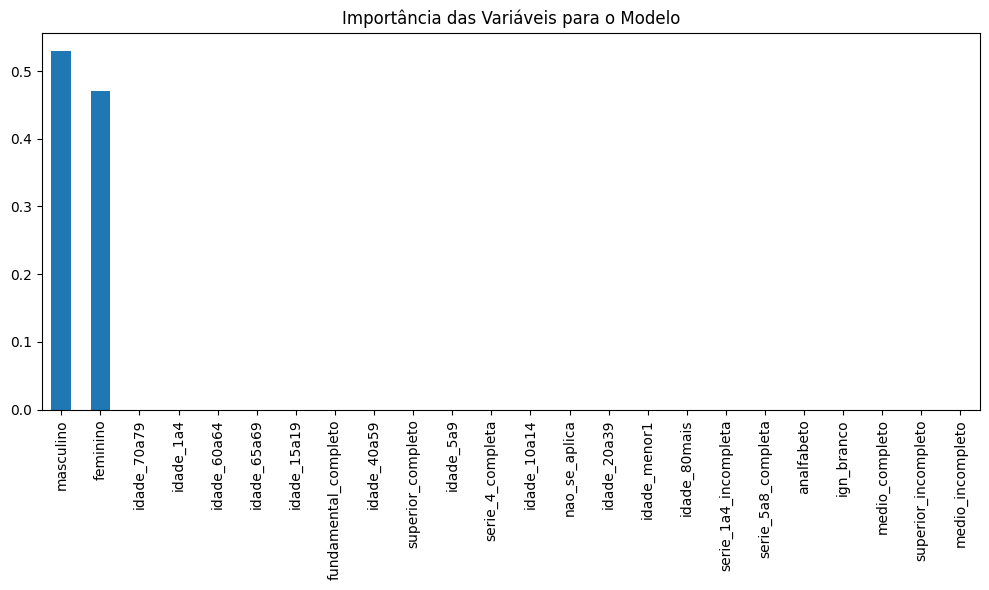

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === ETAPA 1: UNIFICAÇÃO DOS DADOS ===
df_final = df_genero_my_sql.merge(df_educacao_my_sql, on=['cod_uf', 'uf_nome'], how='inner')
df_final = df_final.merge(df_faixa_etaria_my_sql, on=['cod_uf', 'uf_nome'], how='inner')

# === ETAPA 2: SEPARAÇÃO DE FEATURES E TARGET ===
y = df_final['casos_totais']
X = df_final.drop(columns=['cod_uf', 'uf_nome', 'casos_totais'])

# === ETAPA 3: DIVISÃO TREINO/TESTE ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === ETAPA 4: TREINAMENTO DO MODELO ===
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# === ETAPA 5: AVALIAÇÃO ===
y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("🔍 Avaliação do Modelo:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# === ETAPA 6: IMPORTÂNCIA DAS FEATURES ===
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
importancias.plot(kind='bar')
plt.title("Importância das Variáveis para o Modelo")
plt.tight_layout()
plt.show()


### Removendo o Masculino e Feminino

🔍 Avaliação do Modelo (Sem 'masculino' e 'feminino'):
MAE:  98759.92
MSE:  31014068038.33
RMSE: 176108.11
R²:   -0.01


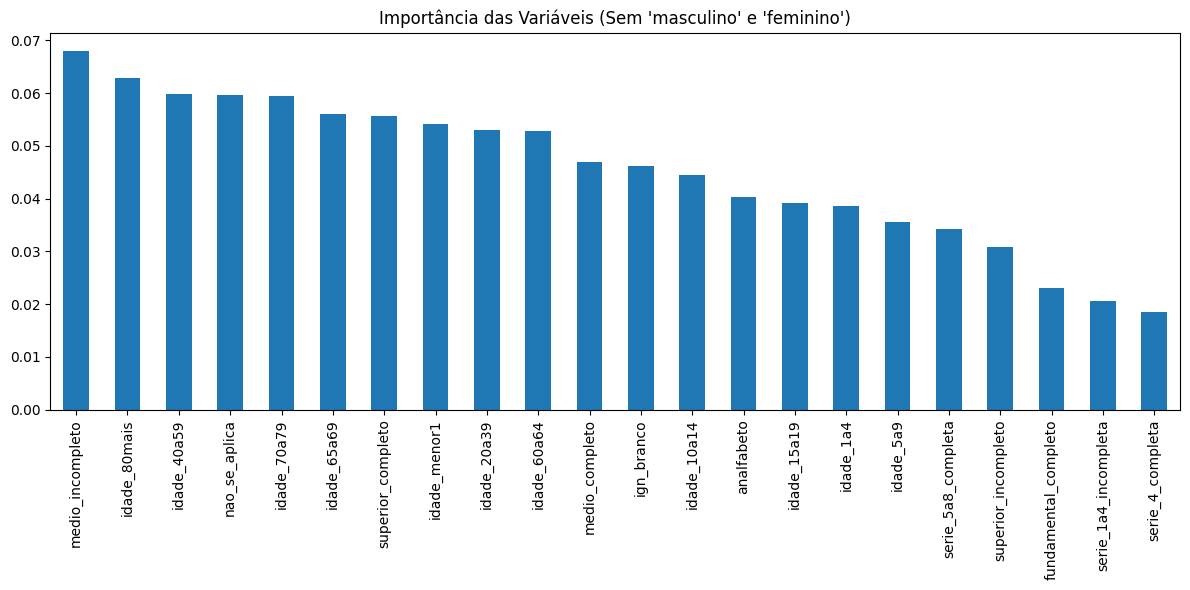

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# === ETAPA 1: PREPARAÇÃO ===
# Alvo
y = df_final['casos_totais']

# Removendo 'masculino' e 'feminino' das features
X = df_final.drop(columns=['cod_uf', 'uf_nome', 'casos_totais', 'masculino', 'feminino'])

# === ETAPA 2: DIVISÃO ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === ETAPA 3: MODELO ===
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# === ETAPA 4: AVALIAÇÃO ===
y_pred = modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("🔍 Avaliação do Modelo (Sem 'masculino' e 'feminino'):")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# === ETAPA 5: IMPORTÂNCIA DAS VARIÁVEIS ===
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importancias.plot(kind='bar')
plt.title("Importância das Variáveis (Sem 'masculino' e 'feminino')")
plt.tight_layout()
plt.show()


#### Nova Classificação

In [17]:
# Criar nova coluna alvo categórica
def classificar_uf(casos):
    if casos < 5000:
        return 'baixo'
    elif casos < 15000:
        return 'medio'
    else:
        return 'alto'

df_final['categoria_casos'] = df_final['casos_totais'].apply(classificar_uf)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Remover colunas de identificação e variáveis colineares
X = df_final.drop(columns=['cod_uf', 'uf_nome', 'casos_totais', 'categoria_casos', 'masculino', 'feminino'])
y = df_final['categoria_casos']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Classificação
modelo_clf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_clf.fit(X_train, y_train)

# Avaliação
y_pred = modelo_clf.predict(X_test)
print("📊 Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("🔀 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


📊 Relatório de Classificação:
              precision    recall  f1-score   support

        alto       0.00      0.00      0.00        24
       baixo       0.93      1.00      0.96       328
       medio       1.00      0.50      0.67         2

    accuracy                           0.93       354
   macro avg       0.64      0.50      0.54       354
weighted avg       0.87      0.93      0.90       354

🔀 Matriz de Confusão:
[[  0  24   0]
 [  0 328   0]
 [  0   1   1]]


c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Versão Balenceada

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Ver distribuição antes de treinar
print("🔎 Distribuição de classes:\n", df_final['categoria_casos'].value_counts())

# Separar features e alvo
X = df_final.drop(columns=['cod_uf', 'uf_nome', 'casos_totais', 'categoria_casos', 'masculino', 'feminino'])
y = df_final['categoria_casos']

# Dividir com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modelo com ajuste para classes desbalanceadas
modelo_balanceado = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

modelo_balanceado.fit(X_train, y_train)

# Previsões
y_pred = modelo_balanceado.predict(X_test)

# Avaliação
print("📊 Relatório de Classificação (com balanceamento):")
print(classification_report(y_test, y_pred))

print("🔀 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


🔎 Distribuição de classes:
 categoria_casos
baixo    1610
alto      149
medio       7
Name: count, dtype: int64
📊 Relatório de Classificação (com balanceamento):
              precision    recall  f1-score   support

        alto       0.06      0.10      0.08        30
       baixo       0.91      0.86      0.89       323
       medio       1.00      1.00      1.00         1

    accuracy                           0.80       354
   macro avg       0.66      0.65      0.66       354
weighted avg       0.84      0.80      0.82       354

🔀 Matriz de Confusão:
[[  3  27   0]
 [ 44 279   0]
 [  0   0   1]]


C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\589557805.py:48: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


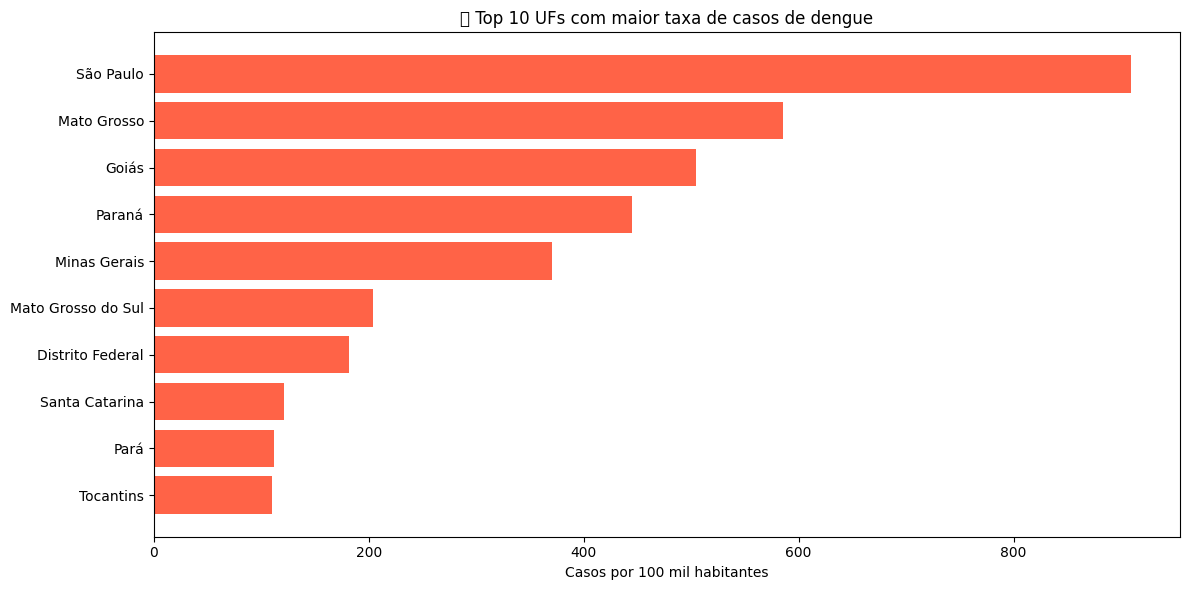

In [20]:
import matplotlib.pyplot as plt


# Aqui um exemplo aproximado só para efeito de visualização:
populacao_aprox = {
    'São Paulo': 46000000,
    'Minas Gerais': 21000000,
    'Rio de Janeiro': 17000000,
    'Bahia': 15000000,
    'Paraná': 11400000,
    'Rio Grande do Sul': 11300000,
    'Pernambuco': 9600000,
    'Ceará': 9200000,
    'Pará': 8700000,
    'Santa Catarina': 7500000,
    'Maranhão': 7100000,
    'Goiás': 7100000,
    'Amazonas': 4200000,
    'Espírito Santo': 4100000,
    'Mato Grosso': 3500000,
    'Paraíba': 4000000,
    'Rio Grande do Norte': 3500000,
    'Alagoas': 3300000,
    'Piauí': 3300000,
    'Distrito Federal': 3100000,
    'Mato Grosso do Sul': 2800000,
    'Sergipe': 2300000,
    'Rondônia': 1800000,
    'Tocantins': 1600000,
    'Acre': 900000,
    'Amapá': 880000,
    'Roraima': 650000
}

# 2. Criar DataFrame auxiliar com taxa por 100 mil
df_taxa = df_final.copy()
df_taxa['populacao'] = df_taxa['uf_nome'].map(populacao_aprox)
df_taxa['casos_por_100k'] = (df_taxa['casos_totais'] / df_taxa['populacao']) * 100000

# 3. Plotar gráfico das 10 UFs com maior taxa
top_ufs = df_taxa.sort_values('casos_por_100k', ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.barh(top_ufs['uf_nome'], top_ufs['casos_por_100k'], color='tomato')
plt.xlabel('Casos por 100 mil habitantes')
plt.title('Top 10 UFs com maior taxa de casos de dengue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\4148095070.py:45: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Pichau\AppData\Local\Temp\ipykernel_22848\4148095070.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Pichau\Desktop\Estudos 4.0\Fiap\3-fase\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


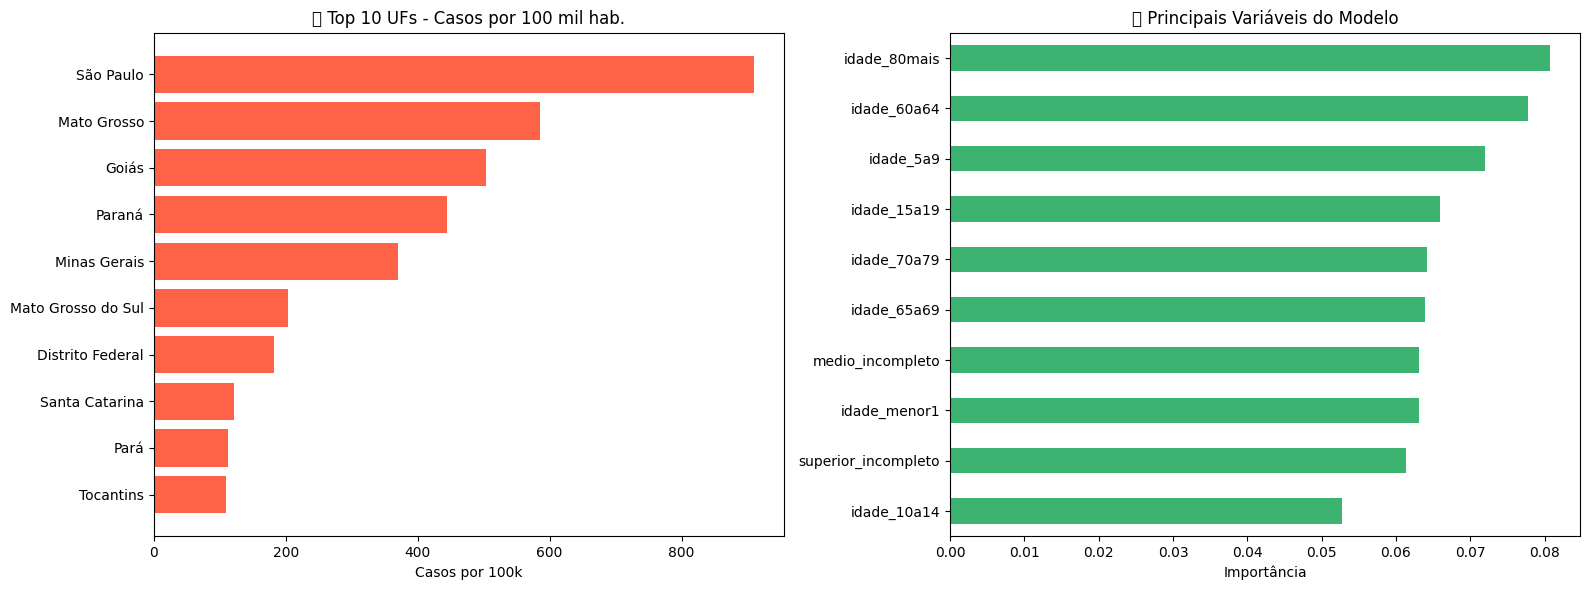

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Taxa por 100k (como antes) ---
df_taxa = df_final.copy()

# Simulação de população (exemplo simplificado)
populacao_aprox = {
    'São Paulo': 46000000, 'Minas Gerais': 21000000, 'Rio de Janeiro': 17000000,
    'Bahia': 15000000, 'Paraná': 11400000, 'Rio Grande do Sul': 11300000,
    'Pernambuco': 9600000, 'Ceará': 9200000, 'Pará': 8700000, 'Santa Catarina': 7500000,
    'Maranhão': 7100000, 'Goiás': 7100000, 'Amazonas': 4200000, 'Espírito Santo': 4100000,
    'Mato Grosso': 3500000, 'Paraíba': 4000000, 'Rio Grande do Norte': 3500000,
    'Alagoas': 3300000, 'Piauí': 3300000, 'Distrito Federal': 3100000,
    'Mato Grosso do Sul': 2800000, 'Sergipe': 2300000, 'Rondônia': 1800000,
    'Tocantins': 1600000, 'Acre': 900000, 'Amapá': 880000, 'Roraima': 650000
}

# Aplicar população e calcular taxa
df_taxa['populacao'] = df_taxa['uf_nome'].map(populacao_aprox)
df_taxa['casos_por_100k'] = (df_taxa['casos_totais'] / df_taxa['populacao']) * 100000

# Top 10 UFs por taxa
top_ufs = df_taxa.sort_values('casos_por_100k', ascending=False).head(10)

# --- Importância das variáveis do modelo de classificação ---
importancias = pd.Series(modelo_balanceado.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False).head(10)

# --- Gráfico lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1 - Taxa por 100k
axes[0].barh(top_ufs['uf_nome'], top_ufs['casos_por_100k'], color='tomato')
axes[0].set_title('Top 10 UFs - Casos por 100 mil hab.')
axes[0].set_xlabel('Casos por 100k')
axes[0].invert_yaxis()

# Gráfico 2 - Importância das variáveis
importancias.plot(kind='barh', ax=axes[1], color='mediumseagreen')
axes[1].set_title('Principais Variáveis do Modelo')
axes[1].set_xlabel('Importância')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [26]:
import joblib

# Supondo que X seja seu DataFrame de features
features = X.columns.tolist()

# Salva modelo e lista de features juntos
joblib.dump((modelo, features), 'modelo/modelo_dengue.pkl')
print("Modelo e features salvos com sucesso!")

Modelo e features salvos com sucesso!


In [24]:
# Listagem de Variáveis para API
features_treinadas = X.columns.tolist()
print(features_treinadas)


['ign_branco', 'analfabeto', 'serie_1a4_incompleta', 'serie_4_completa', 'serie_5a8_completa', 'fundamental_completo', 'medio_completo', 'medio_incompleto', 'superior_incompleto', 'superior_completo', 'nao_se_aplica', 'idade_menor1', 'idade_1a4', 'idade_5a9', 'idade_10a14', 'idade_15a19', 'idade_20a39', 'idade_40a59', 'idade_60a64', 'idade_65a69', 'idade_70a79', 'idade_80mais']
